# RL coursework, part I (20 pts total)
---

**SN:** 20084999  

---

**Due date:** *22nd March, 2022,*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [56]:
# Import Useful Libraries

import collections
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

In [57]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [58]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    
    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif
      
      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward
  
  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]
  
  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [59]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])
      
      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)
      
      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [60]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.
    
    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.
    
    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [61]:
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self._bonus_multiplier = bonus_multiplier
    self.name = name
    self.t = 1
    self.possible_actions = np.arange(self._number_of_arms)
    self.reset()

  def step(self, previous_action, reward):
    # Reward
    if previous_action is not None:
      self.update_q(previous_action, reward)
    # Act
    q = self.q_estimate + self._bonus_multiplier * np.sqrt(np.log(self.t) / (self.action_count + 1e-6))
    action = argmax(q)

    self.t += 1
    self.action_count[action] += 1

    return action

  def reset(self):
    self.q_estimate = np.zeros(self._number_of_arms) 
    self.action_count = np.zeros(self._number_of_arms)
    self.t = 1
  
  def update_q(self, action, reward):
        # simple average update 
        self.q_estimate[action] += 1/self.action_count[action] * (reward - self.q_estimate[action])

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [62]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self.name = name
    self._number_of_arms = number_of_arms
    self.episilon = epsilon
    self.t = 0
    self.possible_actions = np.arange(self._number_of_arms)
    ...
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    self.t += 1
    # Reward
    if previous_action is not None:
      self.update_q(previous_action, reward)

    # Act
    eps = self.episilon
    if callable(self.episilon):
      eps =  self.episilon(self.t)
    
    if np.random.rand() < eps: # explore
        action = np.random.choice(self.possible_actions)
    else:
        action = argmax(self.q_estimate)

    self.action_count[action] += 1
   
    return action

  def reset(self):
    self.q_estimate = np.zeros(self._number_of_arms) 
    self.action_count = np.zeros(self._number_of_arms)
    self.t = 0

  def update_q(self, action, reward):
        # simple average update 
        self.q_estimate[action] += 1/self.action_count[action] * (reward - self.q_estimate[action])

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [63]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self.name = name
    self.average_reward = 0
    self._number_of_arms = number_of_arms
    self.possible_actions = np.arange(self._number_of_arms)
    self.step_size = step_size
    self.baseline = baseline
    self.reset()

  def step(self, previous_action, reward):
    #Reward
    if previous_action is not None:
      self.update_q(previous_action, reward)
    
    #Act
    self.squaremax = np.square(self.p) / np.sum(np.square(self.p))
    
    action = np.random.choice(self.possible_actions, p=self.squaremax)
    self.action_count[action] += 1
    return action

  def reset(self):
    self.action_count = np.zeros(self._number_of_arms)
    self.average_reward = 0
    self.p = np.ones(self._number_of_arms) 

  def update_q(self, action, reward):
    self.average_reward += self.step_size * (reward - self.average_reward)
    baseline = self.average_reward if self.baseline else 0

    mask = np.zeros_like(self.squaremax)
    mask[action] = 1
    self.p += self.step_size * (reward - baseline) * 2 * ((mask / self.p[action]) - (self.p/ np.sum(np.square(self.p))))


# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [64]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

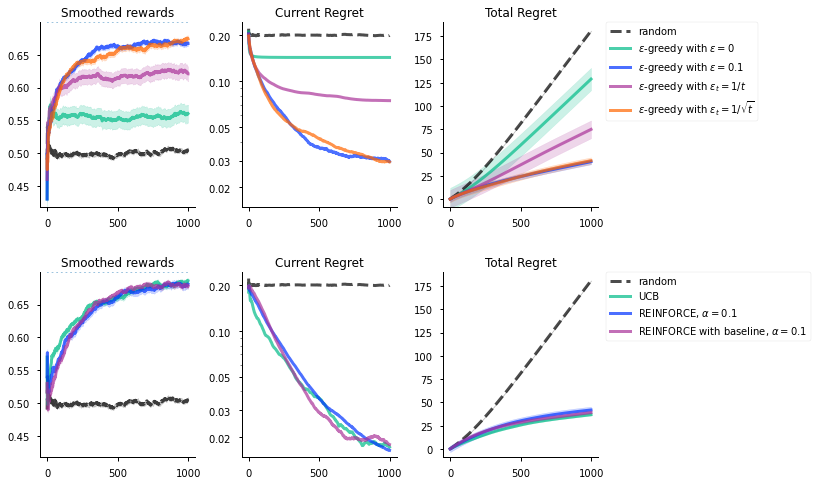

In [65]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

For epsilon greedy:
* $\epsilon$ = 0 is pure greedy so we should expect poor performance due to no exploration. 
* $\epsilon$ = 0.1, we will eventually learn the true Q value, but the total regret will still keep increasing slowing as we'll continue to select actions ramdonly.
* $\epsilon$ = 1/sqrt(t) perform comparably well, and if we learn the true Q value before $\epsilon$ decay to 0, it will act optimally. But they take longer in general compared with UCB and REINFORCE.


For UCB:
* UCB is expected to perform well. Since rewards are the same for each action and the only difference is the payout probabilities, UCB would select all actions in the beginning. It will also choose actions that it has selected less frequently and is less confident in its expected reward prediction. This allow the policies to continue to explore low reward options and speeds up convergence. 

For REINFORCE:
* REINFORCE is also expected to perform well. It explores based on action preferences, thus exploring actions with low expected rewards but less frequently.
 * Adding in a baseline to REINFORCE generally further improves the approach by comparing the action reward to the expected reward and decreasing the preference if the reward is lower than expected. Without this baseline, rewards that are lower than average but higher than the previously predicted reward for this action would shift the action preference higher, even though this is still a worse action selection than others. The baseline also reduces variance of the update, meaning we get better result faster.

**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.

The worst performing approach is $\epsilon$ = 0 as this is a pure exploitation approach. This approach means that the first action that gives a non-zero reward will always be selected. There is a small chance that the first selected action is the optimal but it is unlikely as the number of actions increases. 

The 2nd worst approach for this problem is $\epsilon$ = 1/t. This approach allow early exploration. Early exploration of actions allows the agent to build up a more accurate picture of which action produce a high reward. However, the $\epsilon$ decays too quickly to allow sufficient exploration and will take the sub-optimal action forever afterwards.

$\epsilon$ = 0.1 improves this by allowing continued exploration throughout training, allowing the agent to build up an accurate model of the expected rewards for each action. 
$\epsilon$ = 1/sqrt(t) improves this further by enabling a slow decay of the epsilon value for higher early exploration of all actions. After this early exploration stage, the agent converges on the actions with a high expected reward as decays to a small value.

## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [66]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

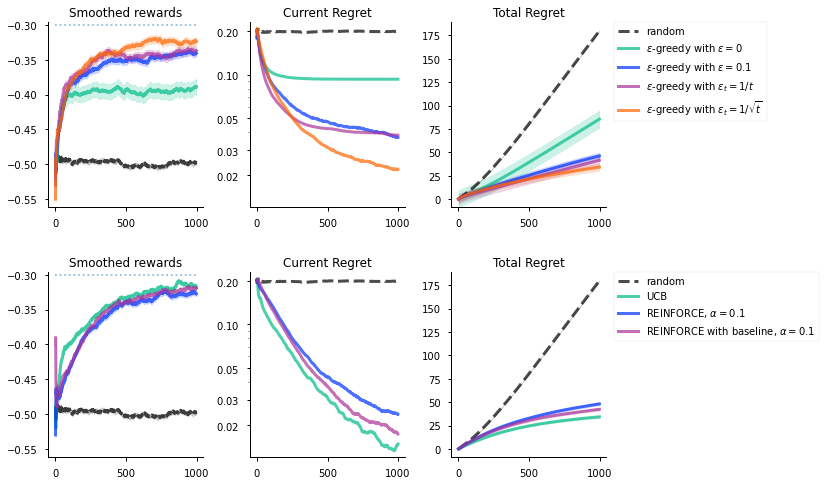

In [67]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

Summary:
Greedy and epsilon-greedy improved slightly. In this setting, since the average reward would be less than or equal to 0. This allows greedy alogorithm to choose acctions that haven't choose before, essentially a form of exploration.

$\epsilon$ = 0 : Performance changed significantly, this is due to the fact we initialise Q=0 for all actions and allow all actions to be explored initialy and the algorithm will choose the most rewarding of the explored actions. 

$\epsilon$ = 0.1 : Performance did not change significantly. The final performance appears slightly closer to , most likely due to both algorithms benefiting from optimistic initialisation.

$\epsilon$ = 1/t : Performance did not change significiantly. This algorithm already encourages early exploration.

$\epsilon$ = 1/sqrt(t) : Performance did not change significantly. The early exploration is independent of the rewards received - derived entirely from random chance, thus scaling the rewards has little effect.

UCB: Performance did not change but this approach again performs best. This method already encourages exploration of all actions at the start and continues to explore under-explored actions throughout the training.

REINFORCE with baseline: The reward's absolute value has little effect. Further, both REINFORCE approaches' action preferences are initialised equally regardless of the rewards.

REINFORCE without baseline: This approach performs slightly better, which may be due to updates only being performed on failures instead of the previous approach where updates are only performed on success (due to the R=0 term in the non-baseline approach). 



## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [68]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [69]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

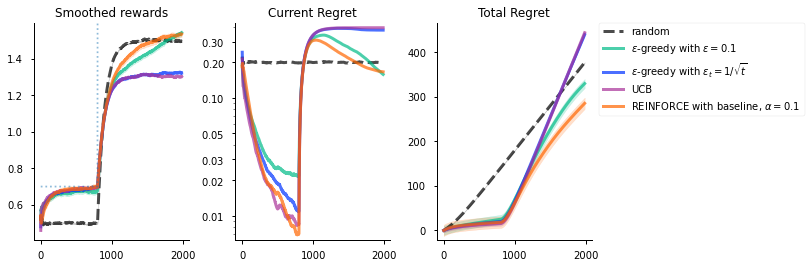

In [70]:
experiment3.show()

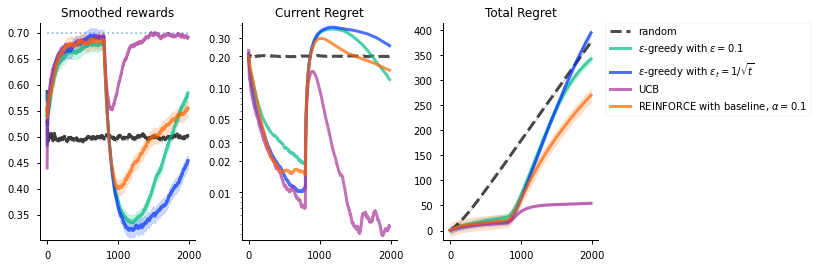

In [71]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

> After 800 steps, the bad actions now yield the greatest reward, with the reward for success remaining constant. The best algorithms for dealing with this approach are REINFORCE and $\epsilon$ =0.1 as both approaches continue to explore throughout training. Leading to selecting the new high reward actions and updating accordingly. For REINFFORCE particularlly, when it sample a "fail" action, the update together with the baseline will make changes to all the preferences at once and therefore will be able to adapt to the new reward distribution.
> For $\epsilon$ = 1/sqrt(t), the $\epsilon$ has already decayed a lot and the upper confidence bound in UCB algorithm will be narrow given the actions have been selected a large number of times. Hence both $\epsilon$ = 1/sqrt(t) and UCB will continue to select the non-optimal actions at this point and are not as good.

**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> Here UCB performs the best and adjusts very quickly, $\epsilon$-greedy with $\epsilon$ = 0.1 also perform well given it will continue to explore lower predicted reward actions and update to the new rewards. REINFORCE with baseline reacts well too but slower than UCB, most likely due to the running average slowing the rate of updates, but given a longer timeframe, we would expect REINFORCE to identify rewarding actions and update its policy.  $\epsilon$-greedy with $\epsilon$ = 1/sqrt(t) is the slowest to adjust due to the already decayed  $\epsilon$. However, Q values will still decrease for the highly exploited previously rewarding actions, leading to the point where it begins to select and exploit the new rewarding actions.

**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> In experiment 3, after 800 step, the uncertainty for all actions would be quite low, hence the actions are picked mostly due to high q-estimate. And since the reward for success is still positive(+1), the q-estimate would not change too much. We have to wait for the upper confidence bound of other actions to slowly increase due to not getting picked as much.
> Contrary to that, in experiment 4, the reward for success becomes zero, hence the q-estimate for the old optimal action will quickly decrease and allow more exploration on the new optimal values. 

**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> From "On Upper-Confidence Bound Policies for Non-Stationary Bandit Problems" (https://arxiv.org/pdf/0805.3415.pdf). The paper proposed two ways. First is to use a discounted UCB,  essentially with a parameter $\gamma$, the algorithm will determine how much weight we put on the latest rewards compared with the earlier ones. Enabling it to adjust quickly to environment change.
$$
  A_t = \max_{a \in A}{(Q(s, a) + 
  c \sqrt{\frac{\log{(t_{\gamma})}}{N_a(\gamma, t)}} )}
$$
$$
  N_a(\gamma, t) = \sum_{s=1}^t \gamma^{t-s} {1}_{[A_t = a]}
$$
$$
  t_{\gamma} = \sum_{s=1}^t \gamma^{t-s}
$$

> The second way would be a sliding window UCB, instead of calculating UCB according to the whole history, we select a window size $\tau$ and only consider up to $\tau$ last play. This avoids the problem of UCB becoming very narrow due to actions selected a large number of times.
